In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cxr-dataset/reports.csv
/kaggle/input/cxr-dataset/projections.csv
/kaggle/input/cxr-dataset/checkpoints_findings/epoch_2/projection_model.pth
/kaggle/input/cxr-dataset/checkpoints_findings/epoch_2/gpt-2-model_fin/config.json
/kaggle/input/cxr-dataset/checkpoints_findings/epoch_2/gpt-2-model_fin/model.safetensors
/kaggle/input/cxr-dataset/checkpoints_findings/epoch_2/gpt-2-model_fin/generation_config.json
/kaggle/input/cxr-dataset/checkpoints_findings/epoch_2/gpt-2-tokenizer_fin/merges.txt
/kaggle/input/cxr-dataset/checkpoints_findings/epoch_2/gpt-2-tokenizer_fin/vocab.json
/kaggle/input/cxr-dataset/checkpoints_findings/epoch_2/gpt-2-tokenizer_fin/tokenizer_config.json
/kaggle/input/cxr-dataset/checkpoints_findings/epoch_2/gpt-2-tokenizer_fin/special_tokens_map.json
/kaggle/input/cxr-dataset/checkpoints_findings/epoch_0/projection_model.pth
/kaggle/input/cxr-dataset/checkpoints_findings/epoch_0/gpt-2-model_fin/config.json
/kaggle/input/cxr-dataset/checkpoints_findings/epoc

In [2]:
import pandas as pd
import numpy as np
import os
import tqdm

from PIL import Image
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [4]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import torchvision
from torchvision import datasets, models, transforms
from torchvision.io import read_image, ImageReadMode
from torchvision.datasets import ImageFolder

from transformers import GPT2Tokenizer
from transformers import GPT2Config
from transformers import GPT2LMHeadModel
from transformers import AdamW

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using CPU


In [6]:
from glob import glob
image_path = "/kaggle/input/cxr-dataset/images/"
images = glob(image_path + "*.png")
len(images)

7470

In [7]:
img_base_dir = '/kaggle/input/cxr-dataset/images'

In [8]:
reports_df = pd.read_csv('/kaggle/input/cxr-dataset/reports.csv')


In [9]:
projections_df = pd.read_csv('/kaggle/input/cxr-dataset/projections.csv')
projections_df.head()

,uid,filename,projection
0,1,1_IM-0001-4001.dcm.png,Frontal
1,1,1_IM-0001-3001.dcm.png,Lateral
2,2,2_IM-0652-1001.dcm.png,Frontal
3,2,2_IM-0652-2001.dcm.png,Lateral
4,3,3_IM-1384-1001.dcm.png,Frontal


In [10]:
class ImageCaptionData:
    def __init__(self, reports_df, projections_df):
        self.reports_df = reports_df.set_index('uid')
        self.projections_df = projections_df.set_index('uid')
        self.uids = reports_df[reports_df.findings.notnull()].uid.unique()
        
    def get_sample(self):
        uid = np.random.choice(self.uids)
        images = list(self.projections_df.loc[[uid]]['filename'])
        projections = list(self.projections_df.loc[[uid]]['projection'])
        findings = self.reports_df.loc[uid]['findings']
        return uid, images, projections, findings

In [11]:
paired_dataset = ImageCaptionData(reports_df, projections_df)
uid, images, projections, findings = paired_dataset.get_sample()

In [12]:
def display_sample(uid, images, projections, findings):
    plt.figure(figsize=(10, 5))
    print("UID:", uid)
    for i, (img, proj) in enumerate(zip(images, projections)):
        plt.subplot(1, len(images), i+1)
        png_img = Image.open(os.path.join(img_base_dir, img))
        png_img = png_img.convert('RGB')
        plt.title(proj)
        plt.imshow(png_img)
        plt.axis('off')
    plt.show()
    print("Findings:", findings)

UID: 1277


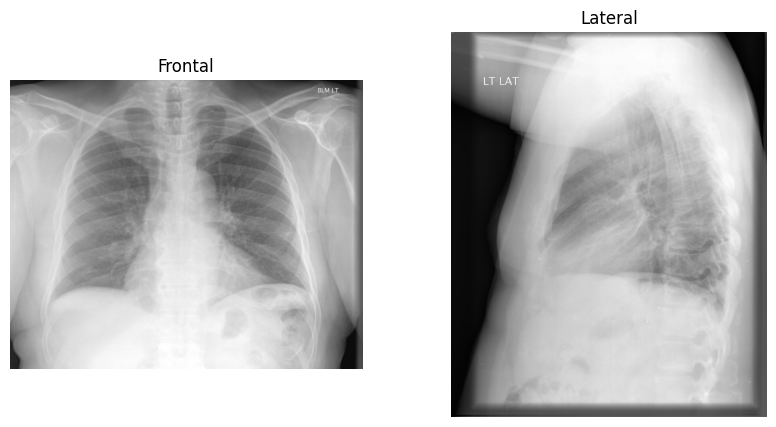

Findings: PA and lateral views the chest were obtained. The cardiomediastinal silhouette is normal in size and configuration. The lungs are well aerated. No pneumothorax, pleural effusion, or lobar air space consolidation. XXXX right middle lobe collapse appears less distinct than on prior study.


In [13]:
display_sample(uid, images, projections, findings)

In [14]:
uids = projections_df.uid.unique()
train_uids, test_uids = train_test_split(uids, test_size=0.1, random_state=42)

Language Model

In [15]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [16]:
findings_corpus = [tokenizer.encode(line)  for line in reports_df[reports_df.uid.isin(train_uids)].findings.dropna()]

In [17]:
pd.Series([len(x) for x in findings_corpus]).describe(percentiles=[0.25, 0.5, 0.75, 0.8, 0.9, 0.95])

count    3003.000000
mean       51.048618
std        22.007258
min         8.000000
25%        37.000000
50%        48.000000
75%        61.000000
80%        67.000000
90%        80.000000
95%        92.000000
max       238.000000
dtype: float64

In [18]:
class GPT2Dataset(Dataset):
    def __init__(self, txt_list, max_length):
        self.input_ids = [torch.tensor(t[:max_length-1] + [tokenizer.eos_token_id]) for t in txt_list]

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, index):
        return self.input_ids[index]

def collate_batch(batch):
    """
    Pad the batch to ensure all sequences have the same length.
    """
    pad_id = tokenizer.pad_token_id
    if pad_id is None:
        pad_id = tokenizer.eos_token_id
    return pad_sequence(batch, batch_first=True, padding_value=pad_id)

# Create dataset
dataset = GPT2Dataset(findings_corpus, max_length=128)  # Adjust max_length as needed
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_batch)

In [19]:
model = GPT2LMHeadModel.from_pretrained('gpt2')
model = model.to(device)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [20]:
sample_reports = list(reports_df[reports_df.uid.isin(test_uids)].findings.dropna().sample(5))

In [21]:
model.eval()
generated_texts = []
with torch.no_grad():
    for smp_report in sample_reports:
        prompt_text = " ".join(smp_report.split()[:5])
        encoded_input = tokenizer.encode(prompt_text, return_tensors='pt')
        encoded_input = encoded_input.to(device) 
        generated_sequences = model.generate(
            input_ids=encoded_input,
            max_length=100,  # Total length of output text (including the prompt)
            num_return_sequences=1,  # Number of sequences to generate
            temperature=0.7,  # Sampling temperature
            top_k=50,  # Top-k filtering
            top_p=0.95,  # Top-p (nucleus) filtering
            no_repeat_ngram_size=2,  # Prevent repetitions of n-grams
            pad_token_id=tokenizer.eos_token_id
        )
        generated_text = tokenizer.decode(generated_sequences[0], skip_special_tokens=True)
        generated_texts.append(generated_text)
for smp, gen in zip(sample_reports, generated_texts):
    print("Sample report:\n", smp)
    print("Generated report:\n", gen)
    print("------------")

Sample report:
 2 images. Heart size and pulmonary vascular engorgement appear within limits of normal. Mediastinal contour is unremarkable. No focal consolidation, pleural effusion, or pneumothorax identified. No convincing acute bony findings.
Generated report:
 2 images. Heart size and weight are also important.

The heart is the most important part of the body. It is responsible for the heart's ability to pump blood to the brain and the blood vessels that carry oxygen to your body, and it is also responsible of keeping your heart healthy. The heart also plays a vital role in the immune system, which is why it helps protect you from infections. If you have a heart problem, you may need to take a blood thinner.
------------
Sample report:
 There is a calcified granuloma in the left upper lung zone. The lungs are otherwise clear. There is hyperinflation. The heart and mediastinum are normal. The skeletal structures and soft tissues are normal for age.
Generated report:
 There is a cal

In [22]:
model.train()
optimizer = AdamW(model.parameters(), lr=5e-5)

NUM_EPOCHS = 3 # Having larger number of epochs here was leading to complete overfitting on the report content
for epoch in range(NUM_EPOCHS):
    for batch in tqdm.auto.tqdm(dataloader):
        optimizer.zero_grad()
        outputs = model(batch.to(device), labels=batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch} completed')

  0%|          | 0/751 [00:00<?, ?it/s]

Epoch 0 completed


  0%|          | 0/751 [00:00<?, ?it/s]

Epoch 1 completed


  0%|          | 0/751 [00:00<?, ?it/s]

Epoch 2 completed


In [23]:
model.eval()
generated_texts = []
with torch.no_grad():
    for smp_report in sample_reports:
        prompt_text = " ".join(smp_report.split()[:5])
        encoded_input = tokenizer.encode(prompt_text, return_tensors='pt')
        encoded_input = encoded_input.to(device) 
        generated_sequences = model.generate(
            input_ids=encoded_input,
            max_length=100,  # Total length of output text (including the prompt)
            num_return_sequences=1,  # Number of sequences to generate
            temperature=0.7,  # Sampling temperature
            top_k=50,  # Top-k filtering
            top_p=0.95,  # Top-p (nucleus) filtering
            no_repeat_ngram_size=2,  # Prevent repetitions of n-grams
            pad_token_id=tokenizer.eos_token_id
        )
        generated_text = tokenizer.decode(generated_sequences[0], skip_special_tokens=True)
        generated_texts.append(generated_text)
for smp, gen in zip(sample_reports, generated_texts):
    print("Sample report:\n", smp)
    print("Generated report:\n", gen)
    print("------------")

Sample report:
 2 images. Heart size and pulmonary vascular engorgement appear within limits of normal. Mediastinal contour is unremarkable. No focal consolidation, pleural effusion, or pneumothorax identified. No convincing acute bony findings.
Generated report:
 2 images. Heart size and pulmonary vascular engorgement appear within limits of normal. Mediastinal contour is unremarkable. No focal consolidation, pleural effusion, or pneumothorax identified. Visualized osseous structures appear intact.
------------
Sample report:
 There is a calcified granuloma in the left upper lung zone. The lungs are otherwise clear. There is hyperinflation. The heart and mediastinum are normal. The skeletal structures and soft tissues are normal for age.
Generated report:
 There is a calcified granuloma in the right lower lobe. There is no focal airspace consolidation. No pleural effusion or pneumothorax. Heart size is within normal limits.
------------
Sample report:
 The cardiomediastinal silhouette

In [24]:
model.save_pretrained('/kaggle/working/gpt-2-model')
tokenizer.save_pretrained('/kaggle/working/gpt-2-tokenizer')

('/kaggle/working/gpt-2-tokenizer/tokenizer_config.json',
 '/kaggle/working/gpt-2-tokenizer/special_tokens_map.json',
 '/kaggle/working/gpt-2-tokenizer/vocab.json',
 '/kaggle/working/gpt-2-tokenizer/merges.txt',
 '/kaggle/working/gpt-2-tokenizer/added_tokens.json')

In [25]:
tokenizer = GPT2Tokenizer.from_pretrained('/kaggle/working/gpt-2-tokenizer')

vision_preprocess = models.swin_transformer.Swin_T_Weights.IMAGENET1K_V1.transforms()

In [26]:
MAX_SEQ_LENGTH  = 128
MAX_IMG_STACK = 5+1
BATCH_SIZE = 4

In [27]:
class ImageCaptionData(Dataset):
    def __init__(self, reports_df, projections_df, max_length=MAX_SEQ_LENGTH, max_img_stack=MAX_IMG_STACK):
        self.reports_df = reports_df.dropna(subset={'findings'}).set_index('uid')
        self.projections_df = projections_df.set_index('uid')
        self.uids = list(set(self.reports_df.index).intersection(self.projections_df.index))
        self.max_length = max_length
        self.max_img_stack = max_img_stack
        
    def __getitem__(self, index):
        uid = self.uids[index]
        image_paths = [os.path.join(img_base_dir, x) for x in list(self.projections_df.loc[[uid]]['filename'])]
        images = torch.stack([vision_preprocess(read_image(img ,ImageReadMode.RGB)) for img in image_paths])
        len_image_stack = len(image_paths)
        img_dim = images[0].shape
        images = torch.cat((torch.zeros((self.max_img_stack - len_image_stack, *img_dim)), images), dim=0)
        
        findings = tokenizer.encode(self.reports_df.loc[uid]['findings'])
        findings = torch.tensor(findings[:self.max_length-1]+ [tokenizer.eos_token_id])
        return len_image_stack, images, findings
    
    def __len__(self):
        return len(self.uids)
    
def collate_batch(batch):
    """
    Pad the batch to ensure all sequences have the same length.
    """
    len_images = torch.tensor([item[0] for item in batch])
    img_data = torch.stack([item[1] for item in batch])
    pad_id = tokenizer.pad_token_id
    if pad_id is None:
        pad_id = tokenizer.eos_token_id
        
    tokens = pad_sequence([item[2] for item in batch], batch_first=True, padding_value=pad_id)
    labels = pad_sequence([torch.cat((torch.tensor([-100]*MAX_IMG_STACK), item[2])) for item in batch], batch_first=True, padding_value=pad_id) 
    return [len_images, img_data, tokens, labels, pad_sequence([torch.ones(len(item[2])+MAX_IMG_STACK) for item in batch], batch_first=True, padding_value=0)]

In [28]:
train_dataset = ImageCaptionData(reports_df[reports_df.uid.isin(train_uids)], projections_df[projections_df.uid.isin(train_uids)])
test_dataset = ImageCaptionData(reports_df[~reports_df.uid.isin(train_uids)], projections_df[~projections_df.uid.isin(train_uids)])

In [29]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

In [30]:
x = next(iter(train_dataloader))
x[0].shape, x[1].shape, x[2].shape, x[3].shape, x[4].shape

(torch.Size([4]),
 torch.Size([4, 6, 3, 224, 224]),
 torch.Size([4, 91]),
 torch.Size([4, 97]),
 torch.Size([4, 97]))

In [31]:
lang_model = GPT2LMHeadModel.from_pretrained('/kaggle/working/gpt-2-model')

In [32]:
vision_model = models.swin_t(weights = models.swin_transformer.Swin_T_Weights.DEFAULT)
vision_model.head = nn.Identity() # strip off classification layer of swin transformer to get the image embedding

Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:01<00:00, 73.8MB/s]


In [33]:
VISION_MODEL_OUTPUT_DIM = 768
LANG_MODEL_INPUT_DIM = 768

In [34]:
class ProjectionModel(nn.Module):
    def __init__(self, vision_out_dim, lang_inp_dim):
        super(ProjectionModel, self).__init__()
        self.lin = nn.Linear(vision_out_dim, lang_inp_dim, bias=True)
    
    def forward(self, x):
        x = nn.functional.tanh(self.lin(x))
        return x

In [35]:
projection_model = ProjectionModel(VISION_MODEL_OUTPUT_DIM, LANG_MODEL_INPUT_DIM)

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [37]:
vision_model = vision_model.to(device)
lang_model = lang_model.to(device)
projection_model = projection_model.to(device)

In [38]:
# freeze vision model
vision_model.eval()
for param in vision_model.parameters():
    param.requires_grad = False

In [39]:
optimizer = torch.optim.Adam(
    [
        {"params": lang_model.parameters(), "lr": 2e-5},
        {"params": projection_model.parameters(), "lr": 5e-5}
    ]
)

In [40]:
NUM_EPOCHS = 5

In [41]:
MODEL_CHECKPOINTS_PATH = '/kaggle/working/checkpoints'
if not os.path.exists(MODEL_CHECKPOINTS_PATH):
    os.makedirs(MODEL_CHECKPOINTS_PATH)

In [42]:
import pdb

In [43]:
best_val_loss = np.inf

In [44]:
train_loss = []
for i in range(NUM_EPOCHS):
    train_batch_loss = []
    
    lang_model.train()
    projection_model.train()
    for l_img, img, tokens, labels, attn in tqdm.auto.tqdm(train_dataloader):
        img, tokens, labels, attn = img.to(device), tokens.to(device), labels.to(device), attn.to(device)
        optimizer.zero_grad()
        with torch.no_grad():
            # refetching bos_embedding to handle cases where bos_embedding might be trainable as well
            bos_embedding = lang_model.get_input_embeddings()(torch.tensor([tokenizer.bos_token_id]*MAX_IMG_STACK).to(device))
            bos_embedding = torch.stack([bos_embedding]*len(l_img))
            mask = torch.stack([torch.cat([torch.ones(MAX_IMG_STACK-limg), torch.zeros(limg)]).repeat(LANG_MODEL_INPUT_DIM,1).T for limg in l_img]).to(device)
            img_embed = vision_model(img.flatten(0,1))
        
        img_embed = projection_model(img_embed).reshape(len(l_img), MAX_IMG_STACK, LANG_MODEL_INPUT_DIM)
        img_embed = bos_embedding*mask + (1-mask)*img_embed # replace images that are not present with bos embedding

        tok_embed = lang_model.get_input_embeddings()(tokens)
        input_embed = torch.cat((img_embed, tok_embed), dim=1)
        outputs = lang_model(
                inputs_embeds=input_embed,
                labels=labels,
                attention_mask=attn,
            )

        loss = outputs.loss
        loss.backward()
        optimizer.step()
        train_batch_loss.append(loss.item()/len(l_img))
        
    train_loss.append(train_batch_loss)
    
    lang_model.eval()
    projection_model.eval()
    aggregated_val_loss = []
    with torch.no_grad():
        for l_img, img, tokens, labels, attn in tqdm.auto.tqdm(test_dataloader):
            img, tokens, labels, attn = img.to(device), tokens.to(device), labels.to(device), attn.to(device)
            
            bos_embedding = lang_model.get_input_embeddings()(torch.tensor([tokenizer.bos_token_id]*MAX_IMG_STACK).to(device))
            bos_embedding = torch.stack([bos_embedding]*len(l_img))
            mask = torch.stack([torch.cat([torch.ones(MAX_IMG_STACK-limg), torch.zeros(limg)]).repeat(LANG_MODEL_INPUT_DIM,1).T for limg in l_img]).to(device)
            img_embed = vision_model(img.flatten(0,1))
        
            img_embed = projection_model(img_embed).reshape(len(l_img), MAX_IMG_STACK, LANG_MODEL_INPUT_DIM)
            img_embed = bos_embedding*mask + (1-mask)*img_embed

            tok_embed = lang_model.get_input_embeddings()(tokens)
            input_embed = torch.cat((img_embed, tok_embed), dim=1)
            outputs = lang_model(
                    inputs_embeds=input_embed,
                    labels=labels,
                    attention_mask=attn,
                )

            loss = outputs.loss
            aggregated_val_loss.append(loss.item()/len(l_img))
    
    print("Epoch:", i, "Train Loss: {:.4f}".format(np.mean(train_batch_loss)), "Val Loss: {:.4f}".format(np.mean(aggregated_val_loss)))
    if (np.mean(aggregated_val_loss)<best_val_loss):
        best_val_loss = np.mean(aggregated_val_loss)
        epoch_checkpoint_path = os.path.join(MODEL_CHECKPOINTS_PATH, 'epoch_'+str(i))
        if not os.path.exists(epoch_checkpoint_path):
            os.makedirs(epoch_checkpoint_path)
        model.save_pretrained(os.path.join(epoch_checkpoint_path, 'gpt-2-model'))
        tokenizer.save_pretrained(os.path.join(epoch_checkpoint_path, 'gpt-2-tokenizer'))
        torch.save(projection_model.state_dict(), os.path.join(epoch_checkpoint_path, 'projection_model.pth'))
        print("Saved checkpoint at "+ epoch_checkpoint_path)

  0%|          | 0/751 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 0 Train Loss: 0.1684 Val Loss: 0.1639
Saved checkpoint at /kaggle/working/checkpoints/epoch_0


  0%|          | 0/751 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 0.1534 Val Loss: 0.1632
Saved checkpoint at /kaggle/working/checkpoints/epoch_1


  0%|          | 0/751 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 2 Train Loss: 0.1458 Val Loss: 0.1622
Saved checkpoint at /kaggle/working/checkpoints/epoch_2


  0%|          | 0/751 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 3 Train Loss: 0.1396 Val Loss: 0.1623


  0%|          | 0/751 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 4 Train Loss: 0.1328 Val Loss: 0.1627


In [45]:
for param_group in optimizer.param_groups:
    param_group['lr'] = param_group['lr']*0.2

In [46]:
BEST_CHECKPOINT_PATH = "/kaggle/working/checkpoints/epoch_2/"
BEST_CHECKPOINT_PATH = epoch_checkpoint_path

In [47]:
VISION_MODEL_OUTPUT_DIM = 768
LANG_MODEL_INPUT_DIM = 768

class ProjectionModel(nn.Module):
    def __init__(self, vision_out_dim, lang_inp_dim):
        super(ProjectionModel, self).__init__()
        self.lin = nn.Linear(vision_out_dim, lang_inp_dim, bias=True)
    
    def forward(self, x):
        x = nn.functional.tanh(self.lin(x))
        return x

In [48]:
def load_best_checkpoint(checkpoint_path):
    vision_preprocess = models.swin_transformer.Swin_T_Weights.IMAGENET1K_V1.transforms()
    
    lang_model = GPT2LMHeadModel.from_pretrained(os.path.join(checkpoint_path, 'gpt-2-model'))
    tokenizer = GPT2Tokenizer.from_pretrained(os.path.join(checkpoint_path, 'gpt-2-tokenizer'))
    
    projection_model = ProjectionModel(VISION_MODEL_OUTPUT_DIM, LANG_MODEL_INPUT_DIM)
    projection_model.load_state_dict(torch.load(os.path.join(checkpoint_path, 'projection_model.pth')))
    
    vision_model = models.swin_t(weights = models.swin_transformer.Swin_T_Weights.DEFAULT)
    vision_model.head = nn.Identity()
    
    vision_model.eval()
    projection_model.eval()
    lang_model.eval()
    return vision_model, projection_model, lang_model, tokenizer, vision_preprocess

In [49]:
vision_model, projection_model, lang_model, tokenizer, vision_preprocess = load_best_checkpoint(BEST_CHECKPOINT_PATH)

In [50]:
vision_model = vision_model.to(device)
lang_model = lang_model.to(device)
projection_model = projection_model.to(device)

In [51]:
def generate_report(image_paths):
    images = torch.stack([vision_preprocess(read_image(img,ImageReadMode.RGB)) for img in image_paths])
    len_image_stack = len(image_paths)

    with torch.no_grad():
        img_embed = vision_model(images.to(device))
        img_embed = projection_model(img_embed)

        # I found that padding here with bos token was actually causing issue with generation
        # probably because for gpt-2 bos_token=eos_token
        padded_img_embed = torch.cat([lang_model.get_input_embeddings()(torch.tensor([tokenizer.bos_token_id]*(MAX_IMG_STACK-len_image_stack)).to(device)), img_embed])

        generate_config = {
                    "eos_token_id": tokenizer.eos_token_id,
                    "bos_token_id": tokenizer.bos_token_id,
                    "pad_token_id": tokenizer.bos_token_id,
                    "max_new_tokens": 100,
                }

        output_ids = lang_model.generate(
            inputs_embeds=img_embed.unsqueeze(0), **generate_config
        )
    return tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0]

In [52]:
def compare_report(uid):
    print("Patient UID:", uid)
    
    uid_projection_df = projections_df[projections_df.uid==uid]
    image_paths = [os.path.join(img_base_dir, img_path) for img_path in uid_projection_df.filename]
    findings = reports_df[reports_df.uid==uid].findings.iloc[0]
    
    plt.figure(figsize=(10, 5))
    for i, (img, proj) in enumerate(zip(image_paths, list(uid_projection_df.projection))):
        if len(image_paths)>1:
            plt.subplot(1, len(image_paths), i+1)
        png_img = Image.open(img)
        png_img = png_img.convert('RGB')
        plt.title(proj)
        plt.imshow(png_img)
        plt.axis('off')
    plt.show()
    print("Findings:", findings)
    generated_report = generate_report(image_paths)
    print("Generated Report:", generated_report)

Patient UID: 327


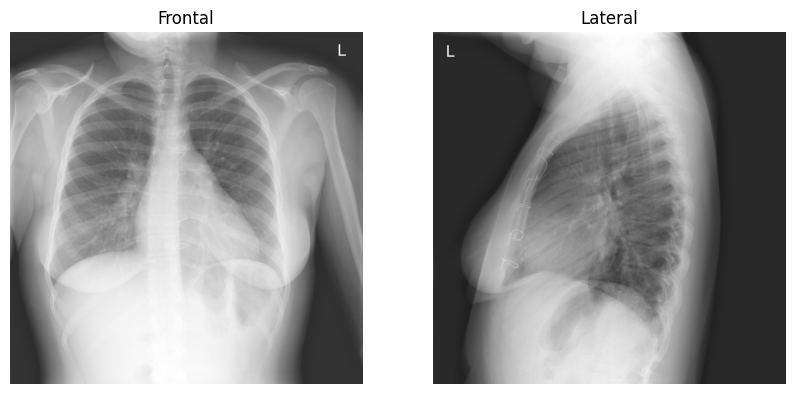

Findings: There is stable, mild cardiomegaly with normal caliber pulmonary vasculature. There are grossly intact XXXX sternotomy XXXX and mediastinal surgical clips. There is no focal airspace disease, pneumothorax, or pleural effusion. There are no acute bony findings.
Generated Report: 


In [53]:
compare_report(np.random.choice(test_uids))

Patient UID: 3555


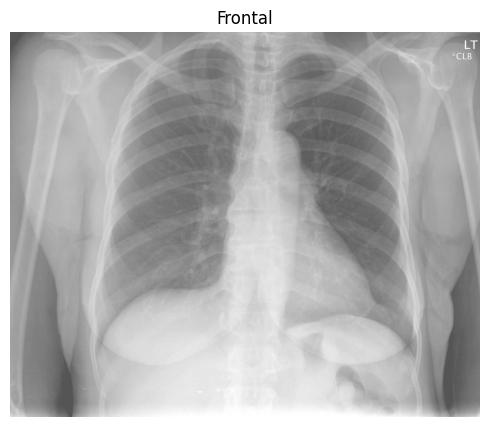

Findings: The heart and mediastinum are unremarkable. The lungs are clear without infiltrate. There is no effusion or pneumothorax. Degenerative disease of multiple midthoracic vertebral bodies.
Generated Report: ungs are clear. No pleural effusions or pneumothoraces. Heart and mediastinum of normal size and contour. Degenerative changes in the spine.


In [54]:
compare_report(3555)

Patient UID: 3638


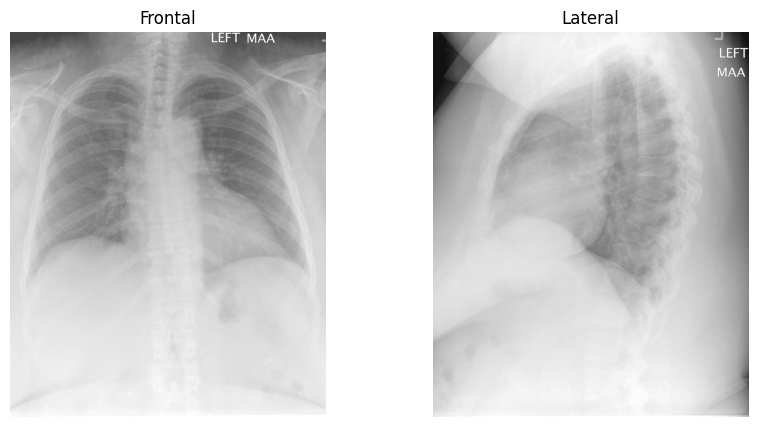

Findings: Cardiomegaly. No pneumothorax or pleural effusion. Clear lung XXXX bilaterally.
Generated Report: c> XXXX XXXX representing the heart size and mediastinal silhouette. The lungs are clear. No pleural effusion or pneumothorax. The XXXX are intact.


In [55]:
compare_report(np.random.choice(test_uids))

Patient UID: 3550


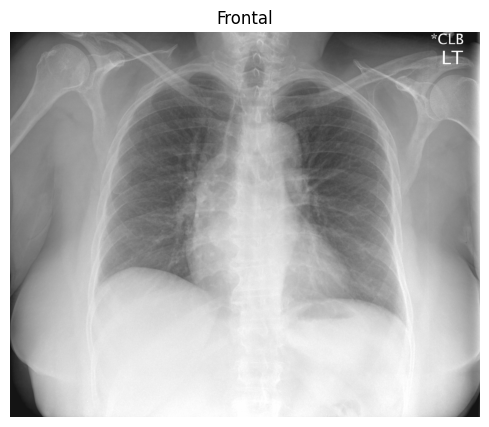

Findings: Normal heart size. Prominent contour of the ascending aorta, consistent with ectasia. Normal mediastinal contours. No focal airspace consolidation. No pleural effusion or pneumothorax. Minimal degenerative changes of the thoracic spine.
Generated Report: ungs are clear. No pleural effusions or pneumothoraces. Heart and mediastinum of normal size and contour. Degenerative changes in the spine.


In [56]:
compare_report(3550)

Patient UID: 1205


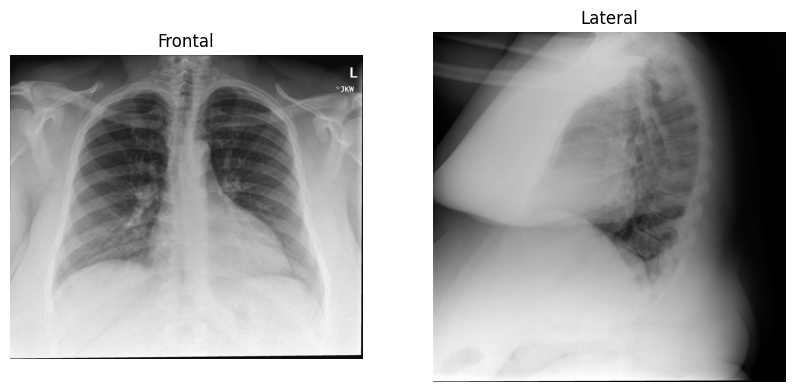

Findings: Normal heart size. Clear lungs without pneumothorax or pleural effusion.
Generated Report: c>


In [57]:
compare_report(np.random.choice(test_uids))

Patient UID: 1175


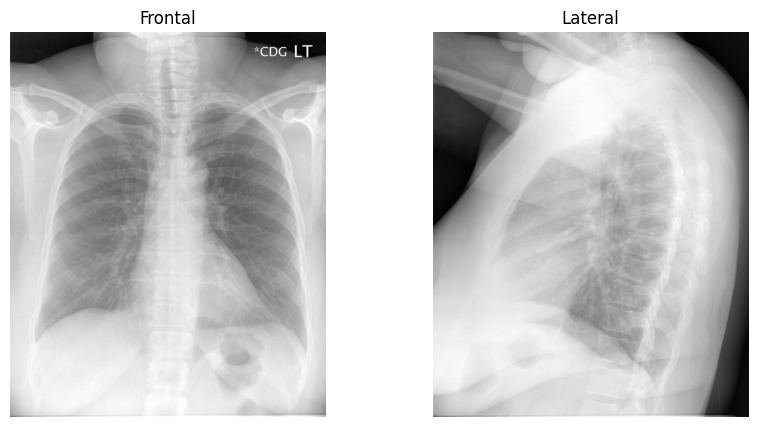

Findings: Both lungs are clear and expanded. Heart and mediastinum normal.
Generated Report: A is present in the right upper lobe. The cardiomediastinal silhouette is normal in size and contour. There is no focal consolidation, pneumothorax or large pleural effusion. There are no acute osseous findings.


In [58]:
compare_report(np.random.choice(test_uids))

Patient UID: 1039


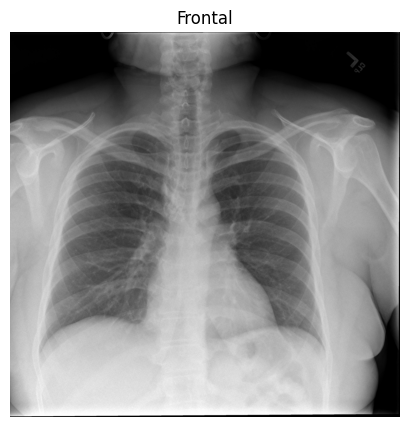

Findings: No pneumothorax or pleural effusion. Normal cardiac contour. Clear lungs bilaterally.
Generated Report: c. XXXX opacities in the right lung base XXXX representing atelectasis. No focal airspace consolidation. No pleural effusion or pneumothorax. Heart size is normal.
Patient UID: 1039


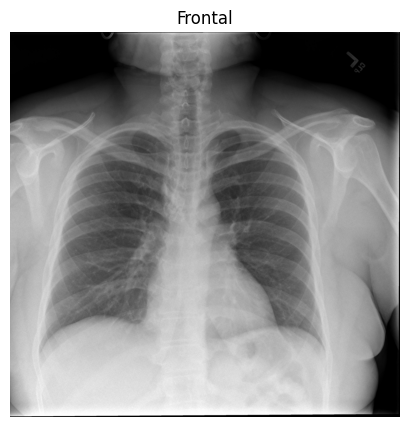

Findings: No pneumothorax or pleural effusion. Normal cardiac contour. Clear lungs bilaterally.
Generated Report: c. XXXX opacities in the right lung base XXXX representing atelectasis. No focal airspace consolidation. No pleural effusion or pneumothorax. Heart size is normal.
Patient UID: 1039


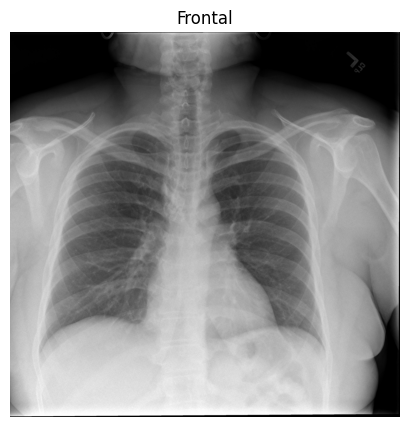

Findings: No pneumothorax or pleural effusion. Normal cardiac contour. Clear lungs bilaterally.
Generated Report: c. XXXX opacities in the right lung base XXXX representing atelectasis. No focal airspace consolidation. No pleural effusion or pneumothorax. Heart size is normal.


In [59]:
uid = np.random.choice(test_uids)
compare_report(uid)
compare_report(uid)
compare_report(uid)

Patient UID: 267


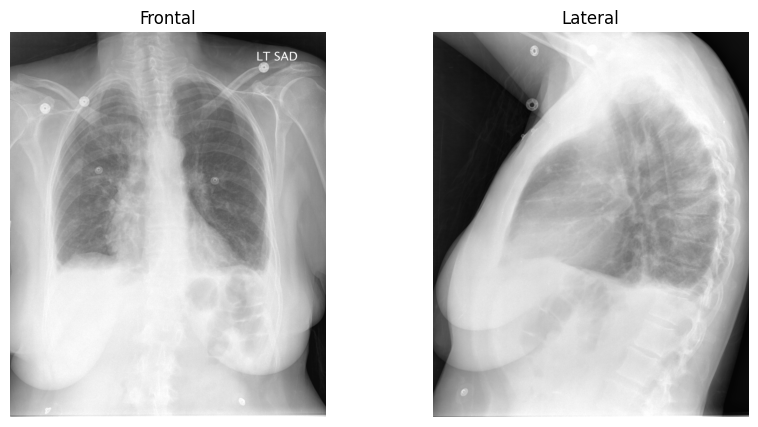

Findings: Endotracheal tube and NG tube have been removed. Mild patchy bilateral airspace disease. There are small bilateral pleural effusions. No pneumothorax. Heart and mediastinum are stable with normal size heart. Degenerative changes in the spine.
Generated Report: c. XXXX XXXX representing the heart size and mediastinal silhouette. The lungs are clear. No pleural effusion or pneumothorax. The XXXX are intact.
Patient UID: 3607


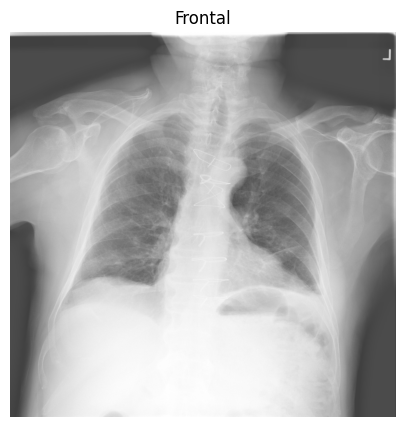

Findings: Heart size and pulmonary vascularity appear within normal limits. The patient is status post CABG. A few XXXX opacities are present in the left base, the appearance which XXXX scarring or atelectasis. No pneumothorax or pleural effusion is seen. Degenerative changes are present in the spine.
Generated Report: cavascular crowding. No focal airspace consolidation. No pleural effusion or pneumothorax. Heart size and mediastinal contour are within normal limits. XXXX XXXX intact.
Patient UID: 2830


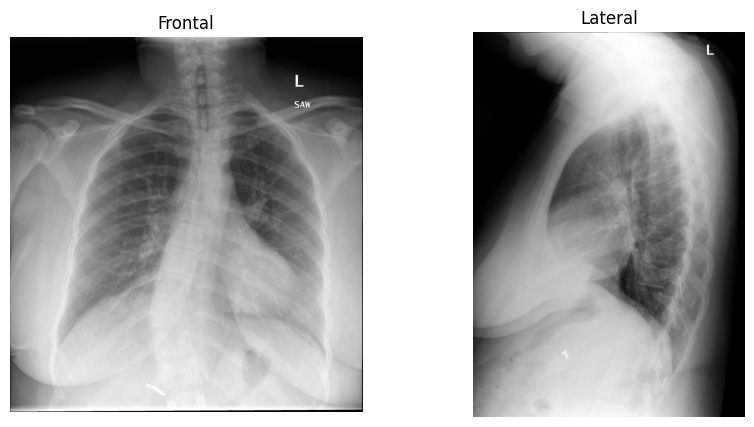

Findings: nan
Generated Report: t XXXX representing a XXXX XXXX representing a chest XXXX. The heart size and mediastinal silhouette are within normal limits for contour. No focal consolidation, pneumothorax or pleural effusion. No acute osseous abnormality.


In [60]:
compare_report(267)
compare_report(3607)
compare_report(2830)